In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [3]:
data = pd.read_csv('DATA/c13_9_2_prep.csv')
data.drop(['Unnamed: 0'], axis=1,inplace = True)
data.head()

,ACC,CAMP,LVL,AWARD,LOA,STAFF,PREVSTAFF,BALS,GAS,PAS,...,DL_T10,DL_T11,DL_T12,DL_T13,DL_T14,DL_T15,DL_T16,DL_T17,DL_T18,DL_T19
0,0,0,3,751.14,101,21,22,46982,46982,2246,...,0,0,0,0,0,0,0,0,0,0
1,1,0,2,416.42,101,18,19,26603,26603,1712,...,0,0,0,0,0,0,0,0,0,0
2,2,0,3,618.44,101,17,16,38605,38605,1765,...,0,0,0,0,0,0,0,0,0,0
3,3,0,5,1221.70,101,25,27,122660,122660,1823,...,0,0,0,0,0,0,0,0,0,0
4,4,0,3,662.57,101,11,11,41806,41806,2422,...,0,0,0,0,0,0,0,0,0,0


In [4]:
%%time
data2 = data.copy()
data2['prev_level'] = data2.groupby(['ACC'])['LVL'].shift()
data2['prev_level_diff'] = data2.groupby(['ACC'])['prev_level'].diff()
data2 = data2.dropna()
data2.head()

Wall time: 17.2 s


In [5]:
data2[data2['ACC'] == 152][['LVL', 'prev_level', 'CAMP']]

,LVL,prev_level,CAMP
96741,4,4.0,2
142735,3,4.0,3
187669,4,3.0,4
232108,4,4.0,5
277827,4,4.0,6
328335,3,4.0,7
381846,3,3.0,8
434318,2,3.0,9
488504,4,2.0,10
545095,3,4.0,11


In [6]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [7]:
def plot_difference(df1, df2, camp):
    import seaborn as sns
    
    grouped = df1.groupby(df1).count()
    grouped2 = df2.groupby(df2).count()
    result = pd.DataFrame(grouped)
    result2 = pd.DataFrame(grouped2)
    
    result.columns = ['count']
    result['lvl'] = result.index
    result['values'] = 'prediction'
    
    result2.columns = ['count']
    result2['lvl'] = result2.index
    result2['values'] = 'actual'
    
    result_r = pd.concat([result, result2])
    
    import seaborn as sns
    sns.set(style="whitegrid")


    # Draw a nested barplot to show survival for class and sex
    g = sns.catplot(x="lvl", y="count", hue="values", data=result_r,
                height=6, kind="bar", palette="muted")
    g.despine(left=True)
    g.set_ylabels(camp)
    
    return 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:3078: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


CAMP 3 - Error 0.38241
CAMP 4 - Error 0.35978
CAMP 5 - Error 0.35246
CAMP 6 - Error 0.37341
CAMP 7 - Error 0.35148
CAMP 8 - Error 0.41029
CAMP 9 - Error 0.34077
CAMP 10 - Error 0.37830
CAMP 11 - Error 0.38836
CAMP 12 - Error 0.36049
Mean Error = 0.36978
Wall time: 2.64 s


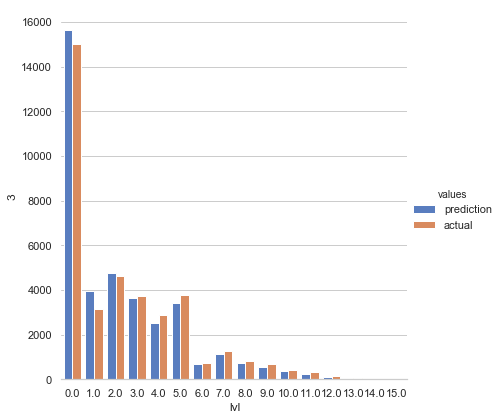

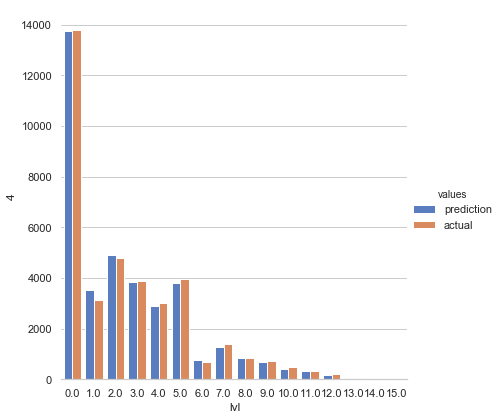

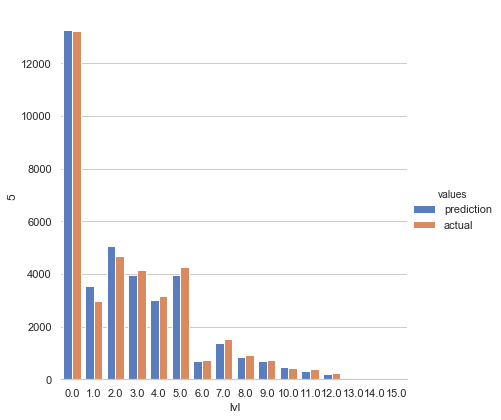

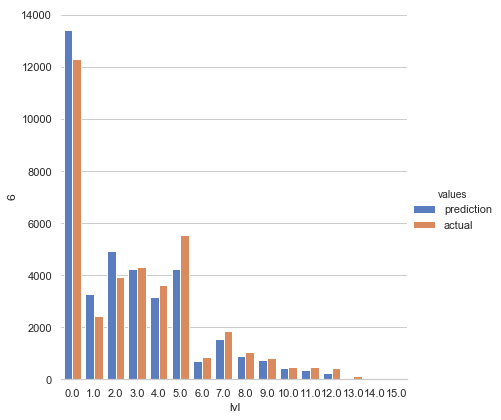

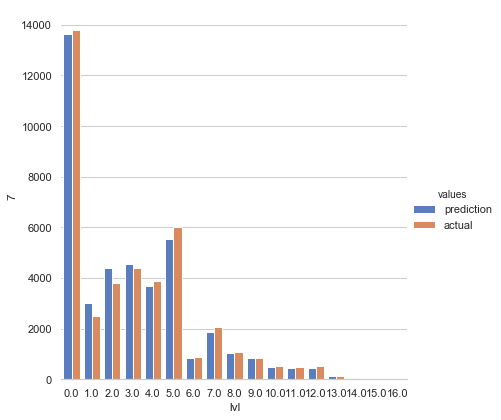

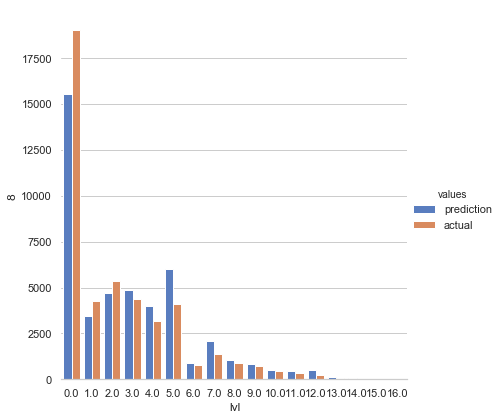

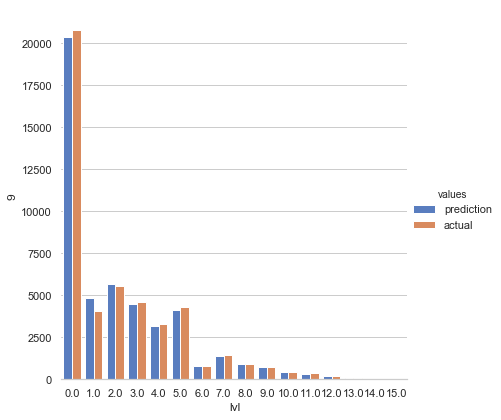

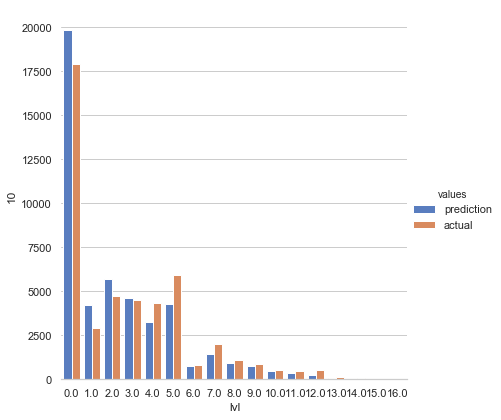

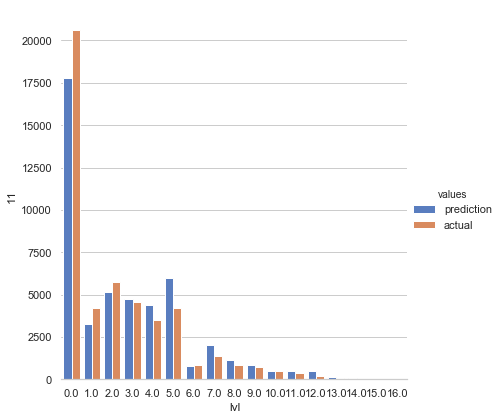

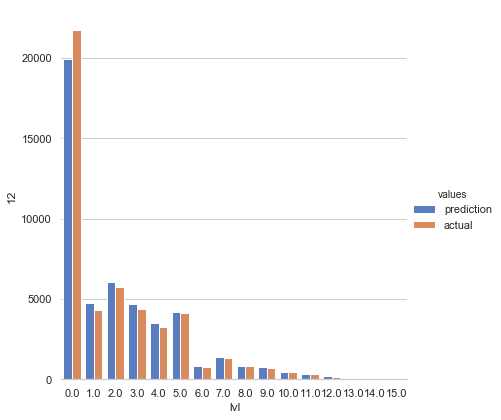

In [19]:
%%time
mean_error = []
df_mean = pd.DataFrame(columns=['LVL_mean'])
for camp in range(3,13):
    train = data2[data2['CAMP'] < camp]
    val = data2[data2['CAMP'] == camp]
    
    p = val['prev_level'].values

    error = rmsle(val['LVL'].values, p)
    plot_difference(val['prev_level'], val['LVL'], camp)
    print('CAMP %d - Error %.5f' % (camp, error))
    mean_error.append(error)

print('Mean Error = %.5f' % np.mean(mean_error))

In [ ]:
%%time
mean_error = []
for camp in range(3,13):
    train = data2[data2['CAMP'] < camp]
    val = data2[data2['CAMP'] == camp]
    
    xtr, xts = train.drop(['LVL'], axis=1), val.drop(['LVL'], axis=1)
    ytr, yts = train['LVL'].values, val['LVL'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))

    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (camp, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

predict = pd.Series(p)
plot_difference(predict, val['LVL'], 12)

Week 3 - Error 0.04006
Week 4 - Error 0.04548
Week 5 - Error 0.04158
Week 6 - Error 0.03912
Week 7 - Error 0.02775
Week 8 - Error 0.02989
Week 9 - Error 0.03350
Week 10 - Error 0.03438
Week 11 - Error 0.03085
Week 12 - Error 0.02999
Mean Error = 0.03526


In [ ]:
%%time
mean_error = []
for camp in range(3,16):
    train = data2[data2['CAMP'] < camp]
    val = data2[data2['CAMP'] == camp]
    
    xtr, xts = train.drop(['LVL'], axis=1), val.drop(['LVL'], axis=1)
    ytr, yts = train['LVL'].values, val['LVL'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (camp, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))